In [182]:
import qutip
import matplotlib.pyplot as plt 
import numpy as np
import scipy.optimize as opt 
import scipy.linalg as linalg
import pickle
import time as timess
import math, cmath
import sys; import time as time
import auxiliary_library as me

from IPython.display import display, Math, Latex
np.set_printoptions(threshold=1.e-9,linewidth=120,precision=3, formatter={"float":lambda x: str(.001*int(1000*x)) })

In [183]:
N = 5; k_B = 1; temp = 5e-01; ts = np.linspace(0, 10,200)

spin_ops_list = me.one_body_spin_ops(N)
identity_op = spin_ops_list[0][0]

### Heisenberg Hamiltonian
chain_type = "XXX"; Hamiltonian_paras = [.2, .15, .1, 1.]
H_H = me.Heisenberg_Hamiltonian(op_list = spin_ops_list, chain_type = chain_type,
                                size = N, Hamiltonian_paras = Hamiltonian_paras,
                                closed_bcs = True, visualization = False)

### classical operators 

cl_ops, label_ops = me.classical_ops(H_H, N, spin_ops_list, False)
print("Are all the operators Hermitian?:", me.basis_hermitian_check(cl_ops))
basis = [identity_op, cl_ops["x_op"]]

Are all the operators Hermitian?: True


In [237]:
def build_rho0_from_basis(basis):
    
    phi0 = [0] + [np.random.rand() for i in range(len(basis)-1)]
    rho0 = (-sum( f*op for f,op in zip(phi0, basis))).expm()
    phi0[0] = np.log(rho0.tr())
    rho0 = (-sum( f*op for f,op in zip(phi0, basis))).expm()
    
    if (me.is_density_op(rho0)):
        pass
    else:
        sys.exit("Not a valid density op")
    return phi0, rho0

def semigroup_phit_sol(phi0, Htensor, ts):
    
    Phi_vector_solution = []
    Phi_vector_solution.append(np.array(phi0))
    
    for i in range(len(ts)-1):
        a = (ts[i+1] * Htensor).expm() * Phi_vector_solution[0]
        Phi_vector_solution.append(a)
    
    return Phi_vector_solution

def semigroup_rhot_sol(rho0, Phi_vector, basis):
    
    rho_at_timet = []
    rho_at_timet.append(rho0)
    
    for i in range(len(Phi_vector)):
        rhot= (-sum( f*op for f,op in zip(Phi_vector[i], basis))).expm()
        rhot = rhot/rhot.tr()
        rho_at_timet.append(rhot)
    
    return rho_at_timet

def semigroup_rhos_test(rho_list, visualization_nonherm, ts):
    
    non_densitiness = []
    for t in range(len(rho_list)-1):
        non_densitiness.append(linalg.norm(rho_list[t] - rho_list[t].dag())/(linalg.norm(rho_list[t])))
        rho_list[t] = .5 * (rho_list[t] + rho_list[t].dag())
            
    if visualization_nonherm:
        x2 = np.arange(len(non_densitiness))
        y2 = non_densitiness
        fig2, ax2 = plt.subplots()
        ax2.plot(x2,y2)
        ax2.legend(loc=0)
        ax2.set_title("Non-hermitian measure for semigroup states")
    
    return rho_list

def find_optimal_depth(max_dif_tolerance, size, Hamiltonian, basis, cl_ops_list, temp, initial_d, ts,
                      visualize_H_evs, visualization_nonherm, visualize_expt_vals):
    
    ts = np.linspace(0, 10,200)
    
    ### useful constants 
    k_B = 1; beta = 1/(k_B * temp); x = .5
    
    ### building the reference state
        
    k_B = 1; temp = 5.; x = .5
    beta = 1/(k_B * temp)
    K = -beta * (1-x) * H_H - x * (cl_ops["n_oc_op"] - 1)**2
    Kmax = max(linalg.eigvals(K).real)
    K = K - Kmax * qutip.tensor([qutip.qeye(2) for k in range(size)]) 
    rho_ref = (K).expm()
    rho_ref = rho_ref/rho_ref.tr()
    
    ### test 1
    if (me.is_density_op(rho_ref)):
        pass
    else:
        sys.exit("Not a valid density op")
        
    basis_incursive = basis + me.recursive_basis(N, initial_d, Hamiltonian, cl_ops["x_op"], rho_ref) 
    basis_orth = me.base_orth(basis_incursive, rho_ref, me.HS_inner_prod_r, False) 
    
    ### test 2
    
    basis_orth, gram_matrix = me.basis_orthonormality_check(basis_orth, rho_ref, me.HS_inner_prod_r)
    
    ### constructing the initial state and H-tensor
    
    phi0, rho0 = build_rho0_from_basis(basis_orth)
    Hijtensor = qutip.Qobj(me.H_ij_matrix(Hamiltonian, basis_orth, rho_ref, me.HS_inner_prod_r)[1])
    
    if visualize_H_evs: 
        x = sorted(np.array(qutip.Qobj(Hijtensor).eigenenergies().real))
        y = sorted(np.array(qutip.Qobj(Hijtensor).eigenenergies().imag))
        z = np.arange(len(x))
        fig1, ax1 = plt.subplots()
        ax1.plot(z,x, label = "Real Part evs")
        ax1.plot(z,y, label = "Iamg part evs")
        ax1.legend(loc=0)
        ax1.set_title("H-tensor's eigenvalues' real and imag part")
        
    ### constructing the coefficient arrays and the physical states 
    
    Phit_list = semigroup_phit_sol(phi0, Hijtensor, ts)
    rhot_list = semigroup_rhot_sol(rho0, Phit_list, basis_orth)
    
    ### test 3
    
    herm_rhot_list = semigroup_rhos_test(rhot_list, visualization_nonherm, ts)
    herm_rhot_list.pop()
    ### Exact solution 
    
    res_exact = qutip.mesolve(H_H, rho0, ts, c_ops=None, e_ops=cl_ops["x_op"])
    res_proj_ev = [qutip.expect(cl_ops["x_op"], rhot) for rhot in herm_rhot_list]
    
    if visualize_expt_vals:
        z = np.arange(len(res_exact.times))
        fig3, ax3 = plt.subplots()
        ax3.plot(z, res_exact.expect[0], label = "Exact")
        ax3.plot(z, res_proj_ev, label = "Manifold-proj")
        ax3.legend(loc=0)
        ax3.set_title("Expected values for x_op - Exact v. Proj. ev. ")
     
    max_diff = max(res_exact.expect[0] - res_proj_ev)
    print(max_diff)
    
    ### plotear una bures de los estados vs t. 
    
    return res_exact, res_proj_ev

Not mean-normalized operator at 0 -th level
1.0000000000000002
The basis is orthonormal


0.022164757018237058


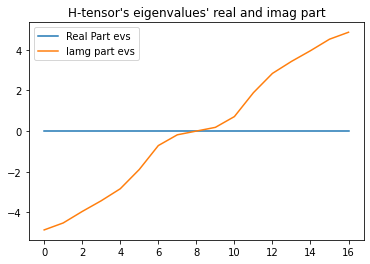

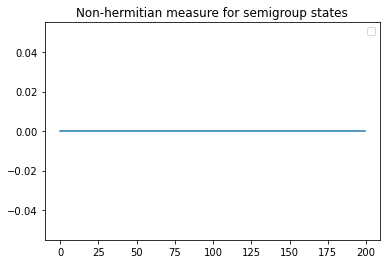

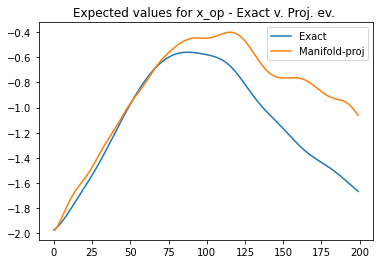

In [239]:
res_exact, res_proj_ev = find_optimal_depth(.1, N, H_H, basis, cl_ops, temp, 16, ts, True, True,True)

# Exact solution using semigroups

In [225]:
-1.8 - (-.6)

-1.2000000000000002

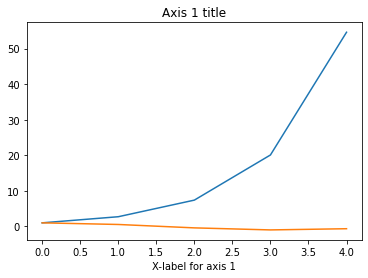

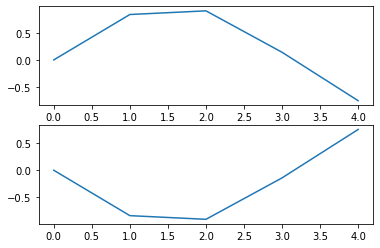

In [218]:
import matplotlib.pyplot as plt
import numpy as np

x = np.arange(5)
y = np.exp(x)
fig1, ax1 = plt.subplots()
ax1.plot(x, y)
ax1.set_title("Axis 1 title")
ax1.set_xlabel("X-label for axis 1")

z = np.sin(x)
fig2, (ax2, ax3) = plt.subplots(nrows=2, ncols=1) # two axes on figure
ax2.plot(x, z)
ax3.plot(x, -z)

w = np.cos(x)
ax1.plot(x, w) # can continue plotting on the first axis

In [ ]:
basis = [cl_ops["identity"], cl_ops["n_oc_op"], cl_ops["n_oc_op"]**2, cl_ops["x_op"], cl_ops["p_op"], 
         cl_ops["p_dot"], cl_ops["comm_xp"], cl_ops["corr_xp"], cl_ops["Neel_op"], H_H]

In [ ]:
res=qutip.mesolve(H_H, rho0, np.linspace(0,200,850), c_ops=None, e_ops=basis[3])
plt.scatter(res.times, res.expect[0], label = "x_op")

plt.scatter(ts1, (qutip.expect(cl_ops["x_op"], rho_at_timet)[:-1]), label = "x_op Proj ev")

plt.xlabel("t")
plt.ylabel("Avgs")
plt.legend()

In [ ]:
res=qutip.mesolve(H_H, rho0, np.linspace(0,200,850), c_ops=None, e_ops=basis[1])
plt.scatter(res.times, res.expect[0], label = "n_oc_op")

plt.scatter(ts1, (qutip.expect(cl_ops["n_oc_op"], rho_at_timet)[:-1]), label = "n_oc_op Proj ev")

plt.xlabel("t")
plt.ylabel("Avgs")
plt.legend()

In [ ]:
res=qutip.mesolve(H_H, rho0, np.linspace(0,200,850), c_ops=None, e_ops=basis[7])
plt.scatter(res.times, res.expect[0], label = "corr_xp Exact")

plt.scatter(ts1, (qutip.expect(cl_ops["corr_xp"], rho_at_timet)[:-1]), label = "corr_xp Proj ev")

plt.xlabel("t")
plt.ylabel("Avgs")
plt.legend()

In [ ]:

res=qutip.mesolve(H_H, rho0, ts1, c_ops=None, e_ops=basis[5])
plt.scatter(res.times, res.expect[0], label = "p_dot E")
plt.scatter(ts1, (qutip.expect(cl_ops["p_dot"], rho_at_timet)[:-1]), label = "p_dot Proj ev")

plt.xlabel("t")
plt.ylabel("Avgs")
plt.legend()

In [ ]:
res=qutip.mesolve(H_H, rho0, np.linspace(0,200,850), c_ops=None, e_ops=basis[8])
plt.scatter(res.times, res.expect[0], label = "Neel_op")

plt.scatter(ts1, (qutip.expect(cl_ops["Neel_op"], rho_at_timet)[:-1]), label = "Neel_op Proj ev")
    
plt.xlabel("t")
plt.ylabel("Avgs")
plt.legend()


# Entropía

### 

In [ ]:
len(ts1)

In [ ]:
res=qutip.mesolve(H_H, rho0, ts1, c_ops=None, e_ops=None)
plt.scatter(ts1, [qutip.entropy_vn(rho) for rho in res.states], label = "Entropy")

plt.scatter(ts1, [qutip.entropy_vn(rho) for rho in rho_at_timet[:-1]], label = "Entropy apprx")
plt.legend()


In [ ]:

res=qutip.mesolve(H_H, rho0, np.linspace(0,200,850), c_ops=None, e_ops=cl_ops("magnetization"))
plt.scatter(res.times, res.expect[0], label = "Mz")

plt.scatter(ts1, (qutip.expect(cl_ops["magnetization"], rho_at_timet)[:-1]), label = "Mz Proj ev")

plt.xlabel("t")
plt.ylabel("Avgs")
plt.legend()

In [ ]:
me.bures(rho_ref, rho0)

In [ ]:
#me.bures(rho_ref, rho_at_timet[500])
#rho_ref = (-.1 * H_H -.9 * (cl_ops["n_oc_op"] - cl_ops["Neel_op"])**2).expm()# .5*(cl_ops["n_oc_op"])**2).expm()


# Numerical Solution with ODEINT

In [ ]:
len(ts1)

In [ ]:
from scipy.integrate import odeint
import random

def F(y, t, H_tensor):
    return H_tensor.dot(y)

ts1 = np.linspace(0, 200, 500)
result = odeint(func=F, y0=phi0,t=ts1,args=(np.real(Hijtensor),))
plt.figure(figsize=(7, 4))

for i in range(len(basis)):
    plt.plot(ts1, result[:,i], label=r'$\phi_{(%d)}(t)$'%i)

plt.xlabel("t")
plt.ylabel("Phi(t)")
plt.legend()

In [ ]:
rho_at_timet_exact_ode = [rho0]

for t in range(len(ts1)):
    loc_K = sum([result[:,i][t] * basis_orth[i] for i in range(len(basis_orth))])
    rhot = (loc_K).expm()
    rhot = rhot/rhot.tr()
    rho_at_timet_exact_ode.append(rhot)
    loc_K = 0
    
res=qutip.mesolve(H_H, rho0, np.linspace(0,200,850), c_ops=None, e_ops=basis)
for index, name in enumerate(["x_op"]):
    plt.scatter(res.times, res.expect[index], label = name)

plt.scatter(ts1, (qutip.expect(cl_ops["x_op"], rho_at_timet_exact_ode )[:-1]), label = "x_op Proj ev with ODE")
plt.scatter(ts1, (qutip.expect(cl_ops["x_op"], rho_at_timet)[:-1]), label = "x_op Proj ev without ODE")

plt.xlabel("t")
plt.ylabel("Avgs")
plt.legend()

# Spin chain exact evolution 

In [ ]:
start_time = time.time()
unitary_ev = True; gamma = None; size = N; gaussian = None; gr = None; xng = None
chain_types = "XXX"; Hamiltonian_paras = [.2, .15, .1, 1.]
obs_basis = basis; ts = np.linspace(0,200,850)

title, ev_paras, resultsB = me.spin_chain_ev(closed_bcs = True, size = size, init_state = rho0, chain_type = chain_types, 
                                             Hamiltonian_paras = Hamiltonian_paras, omega_1=3., omega_2=3., 
                                             temp=1, tmax = 200, deltat = 1, two_body_basis = True, 
                                             unitary_ev = unitary_ev, gamma = gamma, gaussian = gaussian, 
                                             gr = gr, xng = xng, sc_prod = me.HS_inner_prod_r, obs_basis = basis, 
                                             do_project = False)

print("--- %s seconds ---" % (time.time() - start_time))

ev_paras["Time elapsed"] = time.time() - start_time

In [ ]:
plot_labels1 = ["id_Manifold", "n_oc_op", "n_oc_op^2", "x_op", "p_op"] 
plot_labels2 = ["p_dot", "comm_xp", "corr_xp", "Neel_op", "H"]

plt.figure(figsize=(10, 8))

for n in range(len(plot_labels1)):
    plt.scatter(resultsB["ts"], resultsB["averages"][:,n], label=plot_labels1[n] + " Exact")

plt.xlabel("t")
plt.ylabel("Avgs")
plt.title(title)
plt.legend()

In [ ]:
### dinÃƒÂ¡mica 

res=qutip.mesolve(H_H, rho0, np.linspace(0,200,850), c_ops=None, e_ops=basis)
plt.figure(figsize=(10, 8))

for index, name in enumerate(["id_Manifold", "n_oc_op", "n_oc_op^2", "x_op", "p_op"]): #+ ["p_dot", "comm_xp", "corr_xp", "Neel_op","H"]):
    plt.scatter(res.times, res.expect[index], label = name)
    
plt.xlabel("t")
plt.ylabel("Avgs")
plt.legend()


In [ ]:
### dinÃƒÂ¡mica 

res=qutip.mesolve(H_H, rho0, np.linspace(0,200,850), c_ops=None, e_ops=basis)
plt.figure(figsize=(10, 8))

for index, name in enumerate(["p_dot", "comm_xp", "corr_xp", "Neel_op","H"]):
    plt.scatter(res.times, res.expect[index], label = name)
    
plt.xlabel("t")
plt.ylabel("Avgs")
plt.legend()

In [ ]:
plt.figure(figsize=(10, 8))

for n in range(len(plot_labels2)):
    plt.scatter(resultsB["ts"], resultsB["averages"][:,n], label=plot_labels2[n] + " Exact")

plt.xlabel("t")
plt.ylabel("Avgs")
plt.title(title)
plt.legend()

In [ ]:
nabla_t = [[0, -1, 1, 0, 0, 0], [-1, 0, 1, 0, 0, 0], [-1, 1, 0, 0, 0, 0],
          [0, 0, 0, 0, 1, -1], [0,0,0, 1, 0, -1], [0,0,0, 1, -1, 0]]
qutip.Qobj(qutip.Qobj(nabla_t).eigenenergies())